In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [3]:
TRAIN = "..\\UCI HAR Dataset\\UCI HAR Dataset\\train\\"
TEST = "..\\UCI HAR Dataset\\UCI HAR Dataset\\test\\"

# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = TRAIN + "y_train.txt"
y_test_path = TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

In [6]:
# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)

In [7]:
# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training

In [8]:
# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [9]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


In [10]:
def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

In [11]:
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [12]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input], name="input")
y = tf.placeholder(tf.float32, [None, n_classes], name="y_")

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [13]:
pred = LSTM_RNN(x, weights, biases)

In [ ]:
### new
#pred_name = tf.nn.
#pred_softmax = tf.nn.softmax(pred, name="y_")

In [14]:
# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
# L2 loss prevents this overkill neural network to overfit the data

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [15]:
# To keep track of training's performance
saver = tf.train.Saver()

test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_xs, y: batch_ys})
    #_, acc, loss = sess.run([pred, accuracy, cost], feed_dict={x: batch_xs, y: batch_ys})
    
    train_losses.append(loss)
    train_accuracies.append(acc)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run([cost, accuracy], feed_dict={x: X_test, y: one_hot(y_test)})
        #_, acc, loss = sess.run([pred, accuracy, cost], feed_dict={x: X_test, y: one_hot(y_test)})
        test_losses.append(loss)
        test_accuracies.append(acc)
        history['test_loss'].append(loss)
        history['test_acc'].append(acc)
        
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1
#predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={x: X_test, y: one_hot(y_test)})

print("Optimization Finished!")

Training iter #1500:   Batch Loss = 3.163151, Accuracy = 0.14933332800865173
PERFORMANCE ON TEST SET: Batch Loss = 2.4789843559265137, Accuracy = 0.3322022259235382
Training iter #30000:   Batch Loss = 1.388095, Accuracy = 0.6746666431427002
PERFORMANCE ON TEST SET: Batch Loss = 1.519151210784912, Accuracy = 0.6128265857696533
Training iter #60000:   Batch Loss = 1.297313, Accuracy = 0.7020000219345093
PERFORMANCE ON TEST SET: Batch Loss = 1.3726255893707275, Accuracy = 0.69664067029953
Training iter #90000:   Batch Loss = 1.081218, Accuracy = 0.8033333420753479
PERFORMANCE ON TEST SET: Batch Loss = 1.2179169654846191, Accuracy = 0.7668815851211548
Training iter #120000:   Batch Loss = 1.192624, Accuracy = 0.7913333177566528
PERFORMANCE ON TEST SET: Batch Loss = 1.3679561614990234, Accuracy = 0.6990159749984741
Training iter #150000:   Batch Loss = 0.819644, Accuracy = 0.9493333101272583
PERFORMANCE ON TEST SET: Batch Loss = 1.0920838117599487, Accuracy = 0.8204954266548157
Training it

PERFORMANCE ON TEST SET: Batch Loss = 0.5383461713790894, Accuracy = 0.926026463508606
Training iter #1500000:   Batch Loss = 0.396543, Accuracy = 0.940666675567627
PERFORMANCE ON TEST SET: Batch Loss = 0.55534827709198, Accuracy = 0.8971835970878601
Training iter #1530000:   Batch Loss = 0.318904, Accuracy = 0.9639999866485596
PERFORMANCE ON TEST SET: Batch Loss = 0.6195322275161743, Accuracy = 0.894808292388916
Training iter #1560000:   Batch Loss = 0.340548, Accuracy = 0.9506666660308838
PERFORMANCE ON TEST SET: Batch Loss = 0.5720813870429993, Accuracy = 0.8992195725440979
Training iter #1590000:   Batch Loss = 0.365277, Accuracy = 0.9293333292007446
PERFORMANCE ON TEST SET: Batch Loss = 0.5361169576644897, Accuracy = 0.9110960364341736
Training iter #1620000:   Batch Loss = 0.313281, Accuracy = 0.9613333344459534
PERFORMANCE ON TEST SET: Batch Loss = 0.554761528968811, Accuracy = 0.9114353656768799
Training iter #1650000:   Batch Loss = 0.417413, Accuracy = 0.9253333210945129
PERF

In [16]:
## new
predictions, acc_final, loss_final = sess.run([pred, accuracy, cost], feed_dict={x: X_test, y: one_hot(y_test)})

In [18]:
## New
import pickle

pickle.dump(predictions, open("predictions_9ip.p", "wb"))
pickle.dump(history, open("history_9ip.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har_9ip.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har_9ip.ckpt")
#sess.close()

'./checkpoint/har_9ip.ckpt'

In [19]:
history = pickle.load(open("history_9ip.p", "rb"))
#predictions = pickle.load(open("predictions_9ip.p", "rb"))

In [20]:
# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))

FINAL RESULT: Batch Loss = 0.4542688727378845, Accuracy = 0.9134713411331177


Text(0.5,0,'Training iteration')

C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


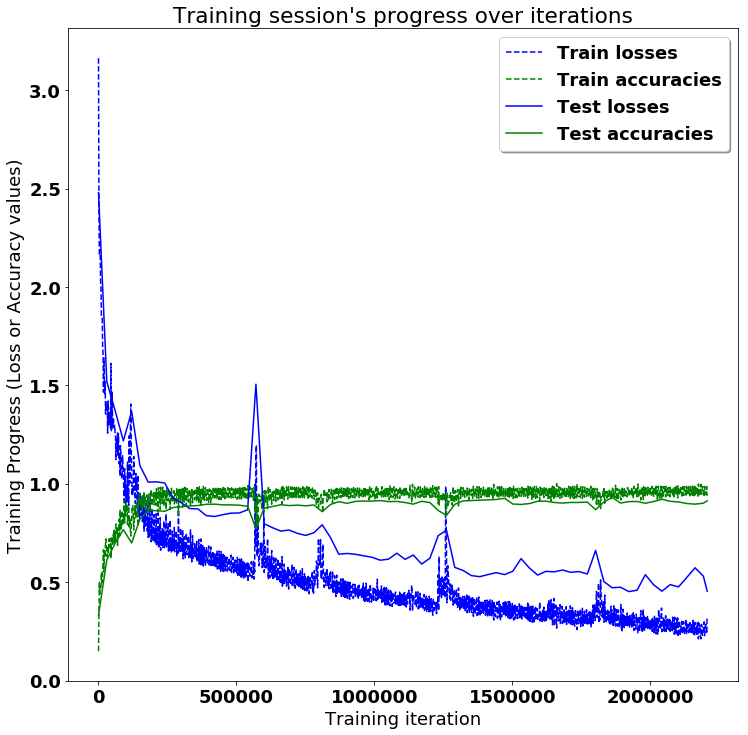

In [21]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12

#fig, ax = plt.subplots()

plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

In [22]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")


Testing Accuracy: 91.34713411331177%

Precision: 91.46163412551176%
Recall: 91.34713267729894%
f1_score: 91.35614835023111%

Confusion Matrix:
[[442  21  13  15   5   0]
 [  7 461   1   1   1   0]
 [  6  18 396   0   0   0]
 [  0   2   5 400  83   1]
 [  1   0   0  71 460   0]
 [  0   1   3   0   0 533]]

Confusion matrix (normalised to % of total test data):
[[14.998303    0.7125891   0.44112659  0.5089922   0.16966406  0.        ]
 [ 0.2375297  15.643027    0.03393281  0.03393281  0.03393281  0.        ]
 [ 0.20359688  0.6107906  13.437393    0.          0.          0.        ]
 [ 0.          0.06786563  0.16966406 13.573125    2.8164234   0.03393281]
 [ 0.03393281  0.          0.          2.4092298  15.609095    0.        ]
 [ 0.          0.03393281  0.10179844  0.          0.         18.08619   ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


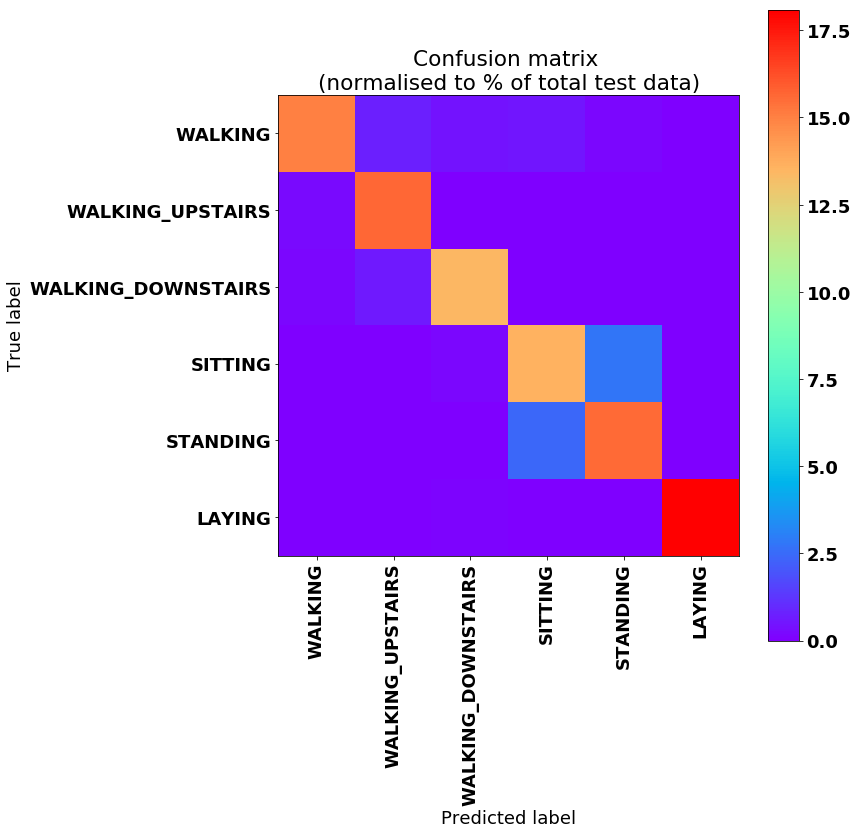

In [23]:
# Plot Results: 
width = 12
height = 12
#fig, ax = plt.subplots()
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
###new

from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har_9ip'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har_9ip.ckpt
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [ ]:
# Freeze the graph

input_graph_path = MODEL_NAME+'.pbtxt'
checkpoint_path = './'+MODEL_NAME+'.ckpt'
input_saver_def_path = ""
input_binary = False
output_node_names = "O"
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
output_optimized_graph_name = 'optimized_'+MODEL_NAME+'.pb'
clear_devices = True


freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")



# Optimize for inference

input_graph_def = tf.GraphDef()
with tf.gfile.Open(output_frozen_graph_name, "r") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def,
        ["I"], # an array of the input node(s)
        ["O"], # an array of output nodes
        tf.float32.as_datatype_enum)


# Save the optimized graph

f = tf.gfile.FastGFile(output_optimized_graph_name, "w")
f.write(output_graph_def.SerializeToString())

# tf.train.write_graph(output_graph_def, './', output_optimized_graph_name)